In [54]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
import seaborn as sns
import os
from PIL import Image
from torch.utils.data import DataLoader, Dataset, Subset
from torchvision import transforms
from sklearn.model_selection import train_test_split
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, ConfusionMatrixDisplay, roc_curve
import random
from tqdm import tqdm 

def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

def medical_priority_score(precision, recall, auc, beta=2):
    """
    Custom score prioritizing recall in medical tasks.
    
    - precision: precision score
    - recall: recall score
    - auc: roc_auc score
    - beta: how much more to weigh recall over precision (default=2)
    """
    weighted_f1 = (1 + beta**2) * (precision * recall) / (beta**2 * precision + recall + 1e-8)
    score = 0.6 * weighted_f1 + 0.4 * auc  # 60% weighted F1, 40% AUC
    return score

def plot_roc_curve(y_true, y_prob, auc, epoch):
    fpr, tpr, _ = roc_curve(y_true, y_prob)
    auc = roc_auc_score(y_true, y_prob)

    plt.figure(figsize=(6, 4))
    plt.plot(fpr, tpr, label=f"AUC = {auc:.4f}", color='dodgerblue', linewidth=2)
    plt.plot([0, 1], [0, 1], 'k--', label="Random", alpha=0.7)
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title(f"ROC Curve" + (f" (Epoch {epoch})" if epoch is not None else ""))
    plt.legend(loc="lower right")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

set_seed(42)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)
print("GPU name:", torch.cuda.get_device_name(0) if torch.cuda.is_available() else "No GPU")

Using device: cuda
GPU name: NVIDIA GeForce RTX 4060 Laptop GPU


In [55]:
torch.cuda.empty_cache()
torch.cuda.ipc_collect()

In [56]:
import gc

gc.collect()  # Python garbage collection
torch.cuda.empty_cache()  # GPU memory
torch.cuda.ipc_collect()  # Extra GPU cleanup (if needed)


In [57]:
df = pd.read_csv('C:\ML\PathoDetect\Data\\train_labels.csv')
print(f"Total images: {len(df)}\n")
print("Class Distribution:", df['label'].value_counts())

Total images: 220025

Class Distribution: label
0    130908
1     89117
Name: count, dtype: int64


### Checking for Class Imbalance

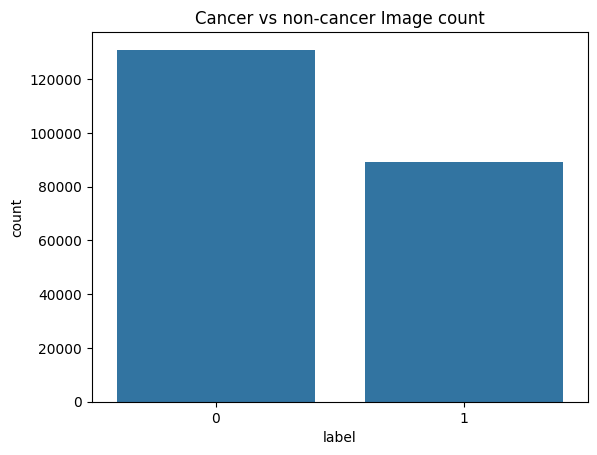

In [58]:
sns.countplot(data=df, x='label')
plt.title("Cancer vs non-cancer Image count")
plt.show()

### Visualizing a few images

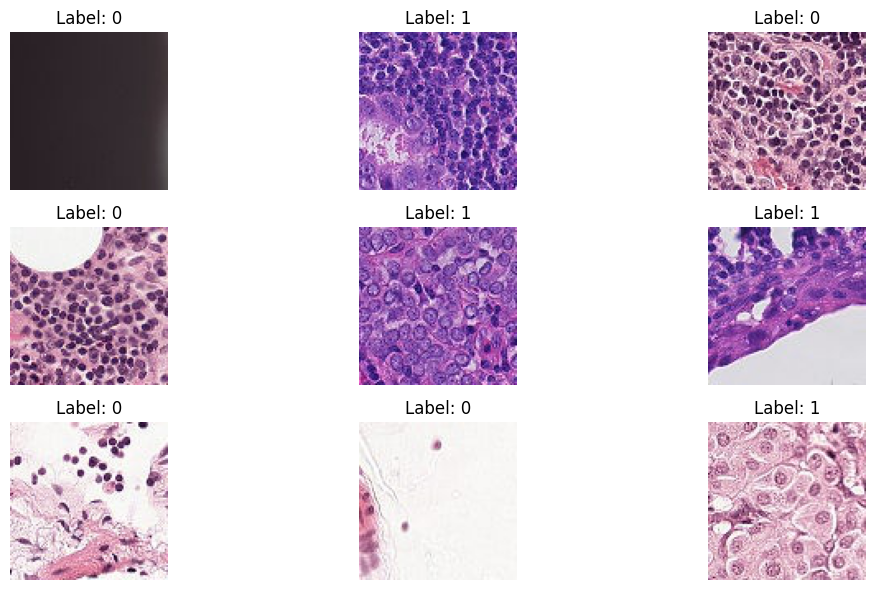

In [59]:
img_dir = r'C:\ML\PathoDetect\Data\train'

sample_ids = df.sample(9)['id'].values

plt.figure(figsize = (12, 6))

for i, img_id in enumerate(sample_ids):
    path = os.path.join(img_dir, img_id+ '.tif') 
    img = Image.open(path)

    plt.subplot(3, 3, i+1) # “Put this image in slot i+1 of a 2-row × 3-column grid”
    plt.imshow(img)
    plt.title(f"Label: {df[df.id == img_id]['label'].values[0]}")
    plt.axis('off')

plt.tight_layout()
plt.show()

- 1 - Cancer 
- 2 - Not Cancer

In [ ]:
class HistopathologyDataset(Dataset):
    def __init__(self, csv_file, img_dir, transform=None, preload=True):
        self.labels_df = pd.read_csv(csv_file)
        self.img_dir = img_dir
        self.transform = transform
        self.preload = preload
        self.cached_data = []

        if not {'id', 'label'}.issubset(self.labels_df.columns):
            raise ValueError("CSV file must contain 'id' and 'label' columns.")

        if self.preload:
            print("📦 Preloading images into RAM...")
            for i in tqdm(range(len(self.labels_df)), desc="Caching images"):
                row = self.labels_df.iloc[i]
                img_id = row['id']
                label = int(row['label'])

                image = self.load_image(img_id)
                if self.transform:
                    image = self.transform(image)

                self.cached_data.append((image, label))
            print(f" Cached {len(self.cached_data)} images in RAM.")

    def __len__(self):
        return len(self.labels_df)

    def load_image(self, img_id):
        img_path = os.path.join(self.img_dir, img_id + '.tif')
        try:
            image = Image.open(img_path).convert("RGB")
        except FileNotFoundError:
            raise RuntimeError(f"Image not found: {img_path}")
        return image

    def __getitem__(self, idx):
        if self.preload:
            return self.cached_data[idx]
        else:
            row = self.labels_df.iloc[idx]
            img_id = row['id']
            label = int(row['label'])

            image = self.load_image(img_id)
            if self.transform:
                image = self.transform(image)

            return image, label

### Plug Into DataLoaders
We'll now:

Split the dataset into train and validation sets

Create PyTorch DataLoaders for batch processing

### Why This Matters:
**DataLoader** lets you iterate in batches (efficient GPU usage)

**Shuffling** during training

Keeps a separate **validation set** to track overfitting

In [61]:
# Defining transforms
# In PyTorch, **transforms** are a set of image preprocessing steps you apply before feeding images into your model.
transform = transforms.Compose([  # This just chains multiple transforms together, in order.
    transforms.Resize((96, 96)),  # Resizes the image to 96×96 pixels, because CNNs need fixed-size input
    transforms.ToTensor()         # This converts the image from a PIL image into a PyTorch Tensor with shape [C, H, W] (Channels, Height, Width)
    # It also Normalizes pixel values from 0–255 → 0–1 (divides all by 255)
    # Like a pixel value of 128 becomes 128 / 255 = 0.502.
])

# Creating Dataset
full_dataset = HistopathologyDataset(
    csv_file='C:/ML/PathoDetect/Data/train_labels.csv',
    img_dir='C:/ML/PathoDetect/Data/train',
    transform=transform,
    preload=False # Set to False to avoid preloading all images into RAM at once
)

# Stratified split for train/val (preserve class ratio)
indices = list(range(len(full_dataset)))  # Creates an index for each image (1, 2, 3, ...)
train_idx, val_idx = train_test_split( 
    indices,
    test_size=0.1,  # Here we are splitting our data into train and validation sets. (90:10)
    stratify=full_dataset.labels_df['label'],  # Keeps the cancer : non-cancer ratio balanced in both sets
    random_state=42
)
# Train_idx -> list of indexes for training images
# val_index -> list of indexes for validation images


### Train and Validation Subsets

In [62]:
# DataLoaders (Loading the data)
train_dataset = Subset(full_dataset, train_idx)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, pin_memory=True, num_workers=0)  # Faster loading with num_workers

val_cached = [full_dataset[i] for i in tqdm(val_idx, desc="Caching validation set")]
val_loader = DataLoader(val_cached, batch_size=64, shuffle=False, pin_memory=True, num_workers=0)  # RAM-based
# Training the whole dataset at a time (batch Gradient Descent) can be done but it is:
# Too slow 
# Memory Heavy
# So, we split the data into smaller chunks like 32 or 64 samples at a time.
# Each batch gets trained, calculated loss and gradients and updates the weights once per batch.

Caching validation set: 100%|██████████| 22003/22003 [00:14<00:00, 1523.52it/s]


⏳ Loading first batch (this may take a few seconds)...


📦 Fetching Batch:   0%|          | 0/1 [00:00<?, ?it/s]

✅ Batch shape: torch.Size([64, 3, 96, 96])
🧷 First 5 labels: [1, 1, 1, 1, 1]


🖼️ Plotting Images: 100%|██████████| 9/9 [00:00<00:00, 147.50it/s]


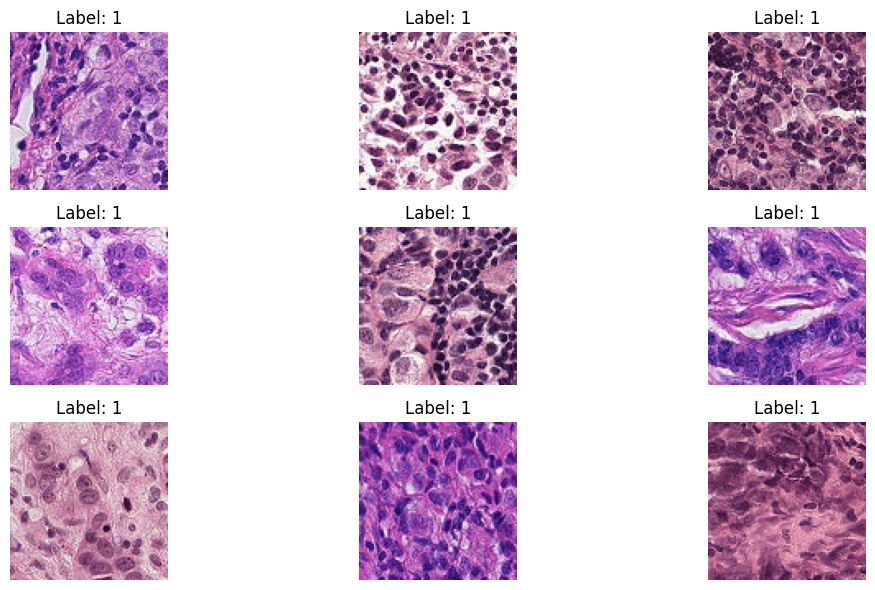

📦 Fetching Batch: 100%|██████████| 1/1 [00:00<00:00,  3.40it/s]


In [63]:
print("⏳ Loading first batch (this may take a few seconds)...")

# tqdm wrapper for clarity (though it's just 1 batch)
for images, labels in tqdm([next(iter(train_loader))], desc="📦 Fetching Batch"):
    print("✅ Batch shape:", images.shape)
    print("🧷 First 5 labels:", labels[:5].tolist())

    # Plot 9 sample images
    plt.figure(figsize=(12, 6))
    for i in tqdm(range(9), desc="🖼️ Plotting Images"):
        img = images[i].permute(1, 2, 0)  # [C, H, W] → [H, W, C]
        plt.subplot(3, 3, i + 1)
        plt.imshow(img)
        plt.title(f"Label: {labels[i].item()}")
        plt.axis('off')

    plt.tight_layout()
    plt.show()

## Building a Model

In [64]:
class CancerClassifierCNN(nn.Module):
    def __init__(self):
        super(CancerClassifierCNN, self).__init__()
          
        # Input : 3 x 96 x 96 [Here 3 are the 3 color channels i.e, Red, Green and Blue]
        self.conv1 = nn.Conv2d(in_channels = 3, out_channels = 16, kernel_size = 3, padding = 1) 
        # 16x96x96 (the 3 input channels are convolved by 16 3D filters resulting in 16 output channels(Feature Maps) You as the model designer decide the number of out channels )
        self.pool = nn.MaxPool2d(kernel_size = 2, stride = 2) # Halves size each time
        # Each of the feature map [out_channels] go through pooling by a 2 x 2 matrix (kernel) by a stride of 2.
        # Resulting each of the feature map to halve in size.

        self.conv2 = nn.Conv2d(16, 32, 3, padding=1) # The 16 feature maps are convolved into 32 out_channels through a 3x3 matrix 
        self.conv3 = nn.Conv2d(32, 64, 3, padding=1) # The 32 feature maps are convolved into 64 out_channels through a 3x3 matrix 

        # After 3 pools -> Final Feature map size = 64 x 12 x 12
        self.fc1 = nn.Linear(64 * 12 * 12, 128)
        self.fc2 = nn.Linear(128, 1) # Binary Output
        
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x))) # [3, 96, 96] -> [16, 48, 48]
        x = self.pool(F.relu(self.conv2(x))) # [16, 48, 48] -> [32, 24, 24]
        x = self.pool(F.relu(self.conv3(x))) # [32, 24, 24] -> [64, 12, 12]

        x = x.view(-1, 64 * 12 * 12) # Flattening for FC Layer
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

### Pooling Process
| Layer       | Channels | H × W         |
| ----------- | -------- | ------------- |
| Input       | 3        | 96 × 96       |
| After Conv1 | 16       | 96 × 96       |
| After Pool1 | 16       | 48 × 48       |
| After Conv2 | 32       | 48 × 48       |
| After Pool2 | 32       | 24 × 24       |
| After Conv3 | 64       | 24 × 24       |
| After Pool3 | 64       | **12 × 12**  |


In [65]:
model = CancerClassifierCNN().to(device)

In [66]:
images = images.to(device)
labels = labels.to(device).float().unsqueeze(1)

### Sanity check evaluation with a subset

 Input shape: torch.Size([64, 3, 96, 96])
 Predicted probabilities: [1.4820883e-04 4.0657226e-02 1.0381117e-03 9.8679966e-01 9.9997067e-01]
 Predicted labels: [0. 0. 0. 1. 1.]
 True labels: [0. 1. 0. 1. 1.]


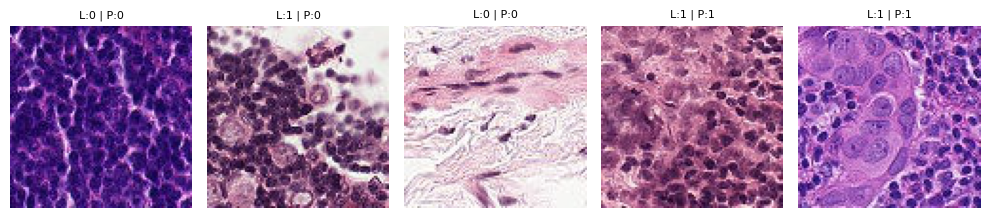

In [74]:
subset_size = 200
# Make sure val_dataset is defined as Subset(full_dataset, val_idx)
indices = random.sample(range(len(val_cached)), subset_size)

# Preload subset data into RAM to avoid slow disk reads
val_subset_cached = [val_cached[i] for i in indices]  # Correctly fetch (image, label) tuples

val_subset_loader = DataLoader(val_subset_cached, batch_size=64, shuffle=False, num_workers=0)

model.eval()
with torch.inference_mode():
    for batch_images, batch_labels in val_subset_loader:
        batch_images = batch_images.to(device)
        batch_labels = batch_labels.to(device).float().unsqueeze(1)

        outputs = model(batch_images)
        probs = torch.sigmoid(outputs)
        preds = (probs > 0.5).float()

        print(" Input shape:", batch_images.shape)
        print(" Predicted probabilities:", probs[:5].cpu().numpy().squeeze())
        print(" Predicted labels:", preds[:5].cpu().numpy().squeeze())
        print(" True labels:", batch_labels[:5].cpu().numpy().squeeze())
        break
    
images_cpu = batch_images.cpu()
labels_cpu = batch_labels.cpu()
preds_cpu = preds.cpu()

fig, axes = plt.subplots(1, 5, figsize=(10, 3))
for i, ax in enumerate(axes):
    img = images_cpu[i].permute(1, 2, 0).numpy()
    ax.imshow(img)
    ax.set_title(f"L:{int(labels_cpu[i])} | P:{int(preds_cpu[i])}", fontsize=8)
    ax.axis('off')

plt.tight_layout()
plt.show()

In [68]:
# Define class imbalance weight
pos_weight = torch.tensor([130908 / 89117], dtype=torch.float32).to(device)
# Loss function for binary classification with imbalance
loss_fn = nn.BCEWithLogitsLoss(pos_weight=pos_weight)
# Optimizer
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [69]:
model = model.to(device)
images = images.to(device)
labels = labels.to(device)

### Training and testing loop

🚀 Using device: cuda
🖥️ GPU: NVIDIA GeForce RTX 4060 Laptop GPU

📘 Epoch 1


🧪 Validating: 100%|██████████| 344/344 [00:03<00:00, 105.87it/s, loss=0.577]



📊 Epoch: 1 | Priority Medical Score: 0.8623 | F1: 0.8220 | Precision: 0.7532 | Recall: 0.9045 | ROC AUC: 0.8514 | Accuracy: 0.8413 | Loss: 0.4062
🧾 Confusion Matrix:
 [[10450  2641]
 [  851  8061]]


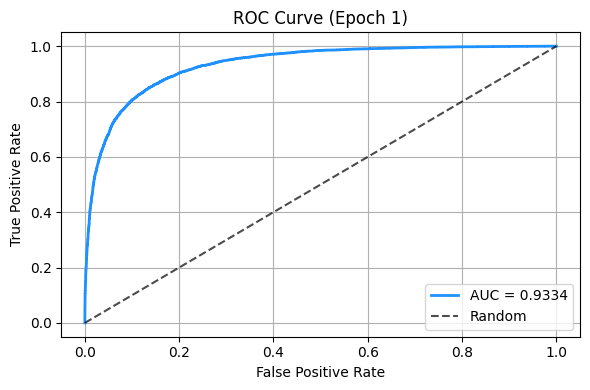

✅ Best model saved (↑ Medical Priority Score)

📘 Epoch 2


🧪 Validating: 100%|██████████| 344/344 [00:03<00:00, 113.12it/s, loss=0.563]



📊 Epoch: 2 | Priority Medical Score: 0.8745 | F1: 0.8680 | Precision: 0.8732 | Recall: 0.8629 | ROC AUC: 0.8888 | Accuracy: 0.8937 | Loss: 0.3268
🧾 Confusion Matrix:
 [[11974  1117]
 [ 1222  7690]]


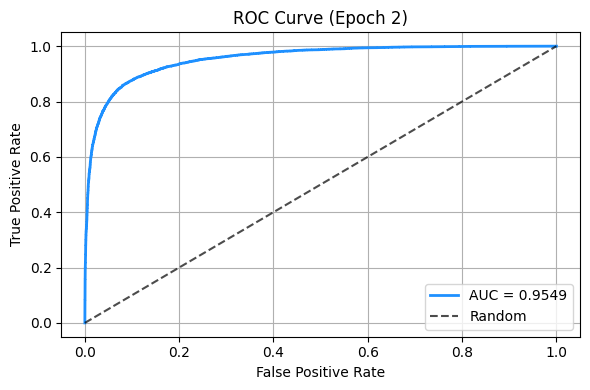

✅ Best model saved (↑ Medical Priority Score)

📘 Epoch 3


🧪 Validating: 100%|██████████| 344/344 [00:03<00:00, 112.53it/s, loss=0.381]



📊 Epoch: 3 | Priority Medical Score: 0.8885 | F1: 0.8803 | Precision: 0.8789 | Recall: 0.8817 | ROC AUC: 0.8995 | Accuracy: 0.9029 | Loss: 0.2900
🧾 Confusion Matrix:
 [[12008  1083]
 [ 1054  7858]]


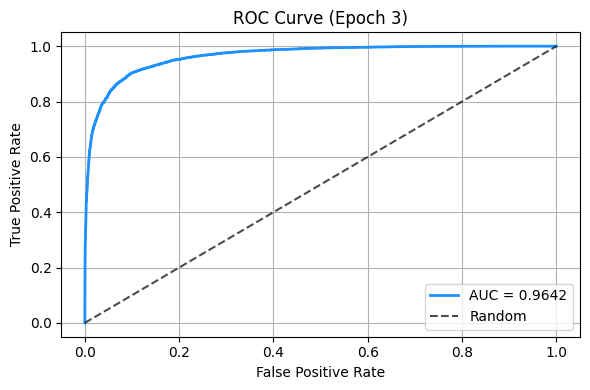

✅ Best model saved (↑ Medical Priority Score)

📘 Epoch 4


🧪 Validating: 100%|██████████| 344/344 [00:02<00:00, 115.20it/s, loss=0.335]



📊 Epoch: 4 | Priority Medical Score: 0.8996 | F1: 0.8763 | Precision: 0.8389 | Recall: 0.9171 | ROC AUC: 0.8986 | Accuracy: 0.8951 | Loss: 0.2869
🧾 Confusion Matrix:
 [[11522  1569]
 [  739  8173]]


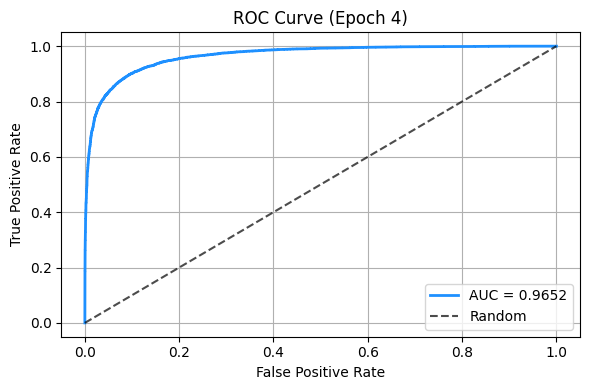

✅ Best model saved (↑ Medical Priority Score)

📘 Epoch 5


🧪 Validating: 100%|██████████| 344/344 [00:03<00:00, 114.59it/s, loss=0.376] 



📊 Epoch: 5 | Priority Medical Score: 0.8877 | F1: 0.8884 | Precision: 0.9091 | Recall: 0.8686 | ROC AUC: 0.9047 | Accuracy: 0.9116 | Loss: 0.2826
🧾 Confusion Matrix:
 [[12317   774]
 [ 1171  7741]]


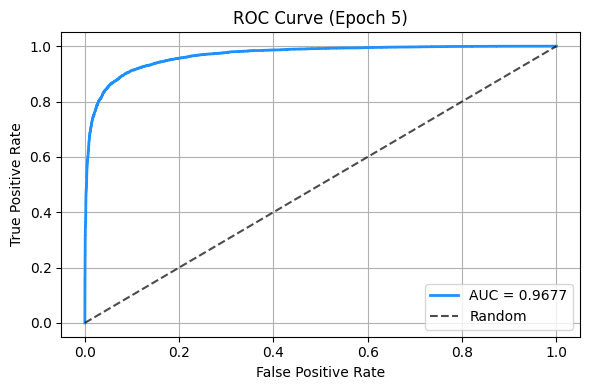


📘 Epoch 6


🧪 Validating: 100%|██████████| 344/344 [00:02<00:00, 115.04it/s, loss=0.296] 



📊 Epoch: 6 | Priority Medical Score: 0.9073 | F1: 0.8930 | Precision: 0.8746 | Recall: 0.9123 | ROC AUC: 0.9116 | Accuracy: 0.9115 | Loss: 0.2577
🧾 Confusion Matrix:
 [[11925  1166]
 [  782  8130]]


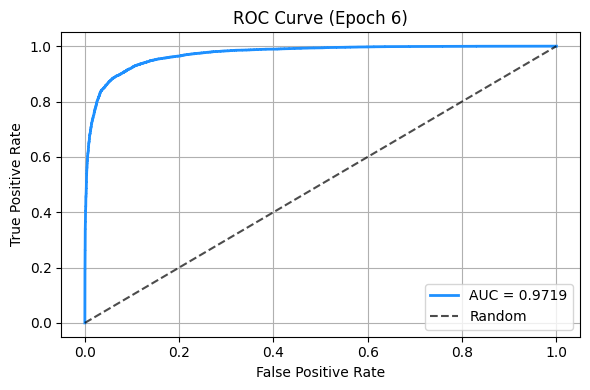

✅ Best model saved (↑ Medical Priority Score)

📘 Epoch 7


🧪 Validating: 100%|██████████| 344/344 [00:02<00:00, 114.75it/s, loss=0.419] 



📊 Epoch: 7 | Priority Medical Score: 0.9019 | F1: 0.8966 | Precision: 0.9000 | Recall: 0.8932 | ROC AUC: 0.9128 | Accuracy: 0.9166 | Loss: 0.2798
🧾 Confusion Matrix:
 [[12207   884]
 [  952  7960]]


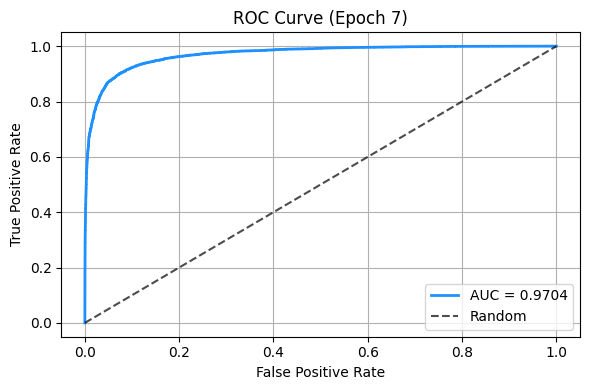


📘 Epoch 8


🧪 Validating: 100%|██████████| 344/344 [00:02<00:00, 114.97it/s, loss=0.31]  



📊 Epoch: 8 | Priority Medical Score: 0.9098 | F1: 0.8899 | Precision: 0.8589 | Recall: 0.9232 | ROC AUC: 0.9100 | Accuracy: 0.9075 | Loss: 0.2703
🧾 Confusion Matrix:
 [[11739  1352]
 [  684  8228]]


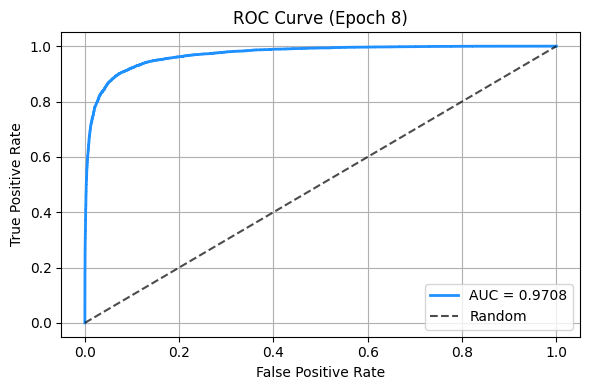

✅ Best model saved (↑ Medical Priority Score)

📘 Epoch 9


🧪 Validating: 100%|██████████| 344/344 [00:03<00:00, 114.64it/s, loss=0.411] 



📊 Epoch: 9 | Priority Medical Score: 0.9002 | F1: 0.8850 | Precision: 0.8656 | Recall: 0.9053 | ROC AUC: 0.9048 | Accuracy: 0.9047 | Loss: 0.3208
🧾 Confusion Matrix:
 [[11838  1253]
 [  844  8068]]


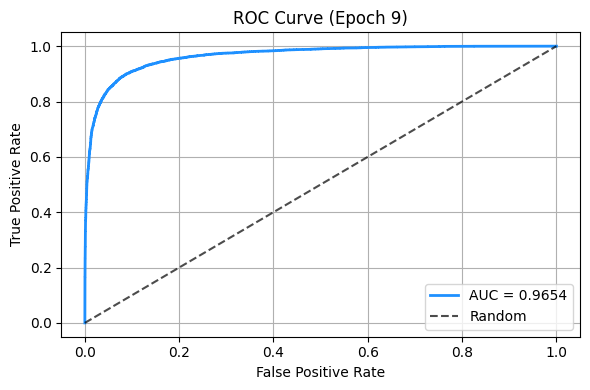


📘 Epoch 10


🧪 Validating: 100%|██████████| 344/344 [00:03<00:00, 114.32it/s, loss=0.514] 



📊 Epoch: 10 | Priority Medical Score: 0.8936 | F1: 0.8860 | Precision: 0.8854 | Recall: 0.8867 | ROC AUC: 0.9043 | Accuracy: 0.9076 | Loss: 0.3505
🧾 Confusion Matrix:
 [[12068  1023]
 [ 1010  7902]]


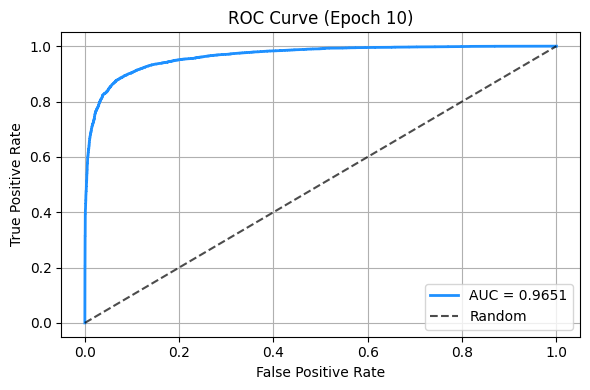

In [ ]:
# Device config
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"🚀 Using device: {device}")
if device.type == 'cuda':
    print(f"🖥️ GPU: {torch.cuda.get_device_name(0)}")

best_mps = 0
epochs = 10

f1_list = []
recall_list = []
precision_list = []
medical_priority_list = []
roc_auc_list = []

for epoch in range(epochs):
    print(f"\n📘 Epoch {epoch+1}")

    model.train()
    train_loader_tqdm = tqdm(train_loader, desc="🔁 Training", leave=True)
    for images, labels in train_loader_tqdm:
        images = images.to(device)
        labels = labels.float().unsqueeze(1).to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = loss_fn(outputs, labels)
        loss.backward()
        optimizer.step()

        train_loader_tqdm.set_postfix(loss=loss.item())

    model.eval()
    total_val_loss = 0
    y_true, y_pred, y_prob = [], [], []

    val_loader_tqdm = tqdm(val_loader, desc="🧪 Validating", leave=True)
    with torch.inference_mode():
        for images, labels in val_loader_tqdm:
            images = images.to(device)
            labels = labels.float().unsqueeze(1).to(device)

            outputs = model(images)
            loss = loss_fn(outputs, labels)
            probs = torch.sigmoid(outputs)
            preds = (probs > 0.5).float()

            total_val_loss += loss.item()
            y_true += labels.cpu().numpy().flatten().tolist()
            y_pred += preds.cpu().numpy().flatten().tolist()
            y_prob += probs.cpu().numpy().flatten().tolist()

            val_loader_tqdm.set_postfix(loss=loss.item())

    avg_loss_val = total_val_loss / len(val_loader)

    # Metrics
    f1 = f1_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, zero_division=0)
    recall = recall_score(y_true, y_pred, zero_division=0)
    cm = confusion_matrix(y_true, y_pred)
    roc = roc_auc_score(y_true, y_pred)
    Priority = medical_priority_score(precision, recall, roc)

    f1_list.append(f1)
    precision_list.append(precision)
    recall_list.append(recall)
    roc_auc_list.append(roc)
    medical_priority_list.append(Priority)

    print(f"\n📊 Epoch: {epoch+1} | Priority Medical Score: {Priority:.4f} | F1: {f1:.4f} | Precision: {precision:.4f} | Recall: {recall:.4f} | "
          f"ROC AUC: {roc:.4f} | Accuracy: {accuracy_score(y_true, y_pred):.4f} | Loss: {avg_loss_val:.4f}")
    print("🧾 Confusion Matrix:\n", cm)
    plot_roc_curve(y_true, y_prob, roc, epoch=epoch+1)

    if Priority > best_mps:
        best_mps = Priority
        torch.save({'model_state': model.state_dict(),
                   'epoch': epoch,
                   'f1_score': f1,
                   'roc_score': roc,
                   'precision': precision,
                   'Priority': Priority}, 
                   "best_cnn_model.pth")
        print("✅ Best model saved (↑ Medical Priority Score)")
